# DEEP LEARNING - PRACTICUM 02a

- Diego Roca Rodríguez
- Roi Santos Ríos

In this practicum we will various RNN models in order to solve a prediction problem for time series. This is the main file of the practicum, where we discuss the final results that we've obtained with all the approaches that we tried.

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

2023-04-13 09:28:07.640513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Returns a numpy array with size nrows x ncolumns-1. nrows and ncolums are the rows and columns of the dataset
#the Date column is skipped (ncolumns-1)
def readData(fname):
    with open(fname) as f:
        fileData = f.read()
  
    lines = fileData.split("\n")
    header = lines[0].split(",")
    lines = lines[1:] 
    #print(header) 
    #print("Data rows: ", len(lines))

    rawData = np.zeros((len(lines), len(header)-1)) #skip the Date column

    for i, aLine in enumerate(lines):       
        splittedLine = aLine.split(",")[:]
        rawData[i, 0] = splittedLine[0]
        rawData[i, 1:] = [float(x) for x in splittedLine[2:]] 

    return rawData

In [3]:
#Returns the train and test data, normalized. It also returns the standard deviation of Weekly_Sales
#Each list has a size equal to the number of stores
#For each store there is a list of size trainNSamples (testNSamples) x nColums-1 (the store id is skipped)
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
def splitTrainTest(rawData, testPercent):

    listStore = np.unique(rawData[:, 0])
    trainNSamples = np.zeros(len(listStore))
    
    for i, storeId in enumerate(listStore):
        trainNSamples[i] = np.count_nonzero(rawData[:, 0] == storeId)
    trainNSamples = np.floor((1-testPercent) *  trainNSamples)

    tmpTrain = np.zeros((int(np.sum(trainNSamples)), len(rawData[0])))

    store = -1
    counter = 0
    counterTrain = 0
    storeDict = dict(zip(listStore, trainNSamples))
    for i, aLine in enumerate(rawData):
        if store != aLine[0]:
            store = int(aLine[0])
            counter = 0
        if(counter < storeDict.get(store)):
            tmpTrain[counterTrain] = rawData[i][:]
            counterTrain += 1
            counter += 1

    meanData = tmpTrain.mean(axis=0)
    stdData = tmpTrain.std(axis=0)
    rawNormData = (rawData - meanData) / stdData

    allTrain = list()
    allTest = list()
    store = -1
    counter = 0
    for i, aLine in enumerate(rawNormData):
        splittedLine = [float(x) for x in aLine[1:]] #skip store id
        if store != rawData[i][0]:
            if i != 0:
                allTrain.append(storeDataTrain)
                allTest.append(storeDataTest)
            store = int(rawData[i][0])
            storeDataTrain = list()
            storeDataTest = list()
            counter = 0

        if(counter < storeDict.get(store)):
            storeDataTrain.append(splittedLine)
            counter += 1
        else:
            storeDataTest.append(splittedLine)

        if i == len(rawNormData)-1:
            allTrain.append(storeDataTrain)
            allTest.append(storeDataTest)

    return allTrain, allTest, stdData[1] #std of wSales

In [4]:
#generates a time series given the input and ouput data, the sequence length and the batch size
#seqLength is the number of weeks (observations) of data to be used as input
#the target will be the weekly sales in 2 weeks
def generateTimeSeries(data, wSales, seqLength, batchSize):   
    sampling_rate = 1 #keep all the data points 
    weeksInAdvance = 3
    delay = sampling_rate * (seqLength + weeksInAdvance - 1) #the target will be the weekly sales in 2 weeks
    
    dataset = keras.utils.timeseries_dataset_from_array(
        data[:-delay],
        targets=wSales[delay:],
        sampling_rate=sampling_rate,
        sequence_length=seqLength,
        shuffle=True,
        batch_size=batchSize,
        start_index=0)
    
    return dataset


In [5]:
def printTimeSeriesList(theList):
    print('list length', len(theList))
    print('First element')
    input, target = theList[0]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])
    print('Last element')
    input, target = theList[-1]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])

In [6]:
#returns the training and test time series
#it also returns the standard deviation of Weekly_Sales, and the number of input features
def generateTrainTestData(fileName, testPercent, seqLength, batchSize):
    rawData = readData(os.path.join(fileName))
    allTrain, allTest, stdSales = splitTrainTest(rawData, testPercent)
    
    for i in range(len(allTrain)):
        tmp_train = generateTimeSeries(np.array(allTrain[i]), np.array(allTrain[i])[:,0], seqLength, batchSize)
        tmp_test = generateTimeSeries(np.array(allTest[i]), np.array(allTest[i])[:,0], seqLength, batchSize)

        if i == 0:
            train_dataset = tmp_train
            test_dataset = tmp_test
        else:
            train_dataset = train_dataset.concatenate(tmp_train)
            test_dataset = test_dataset.concatenate(tmp_test)
    
    return train_dataset, test_dataset, stdSales, np.shape(allTrain)[2]

In [7]:
#generateTrainTestData(fileName, testPercent, seqLength, batchSize):
#trainData, testData: each element comes from keras.utils.timeseries_dataset_from_array, i.e., is a time series
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment

testPercent = 0.2
seqLength = 12
batchSize = 1
trainData, testData, stdSales, nFeatures = generateTrainTestData("data/walmart-sales-dataset-of-45stores.csv",
    testPercent, seqLength, batchSize) 

2023-04-13 09:28:09.449317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 09:28:09.450492: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Approaches
### sequence length = 8
- Basic RNN -> 92961 MAE
- Basic GRU -> 64203 MAE
- Recurrent dropout LSTM -> 109091 MAE (WORST)
- Stacked GRU layers -> 76601 MAE
- Bidirectional LSTM -> 70992 MAE
### sequence length = 12
- Basic RNN -> 79513 MAE
- Basic GRU -> 62146 MAE
- Recurrent dropout LSTM -> 70014 MAE
- Stacked GRU layers -> 59686 MAE
- Bidirectional LSTM -> 53801 MAE (BEST)

# Basic RNN

### sequence length = 8
This was the first tested approach (all discussion regarding the results takes into account 68.000 as a good result, as stipulated by the problem description), and its results aren't good at all. The dimensionalities tested were 16, 32 and 48, and neither of them showed good results.

### sequence length = 12
The increase in sequence length imporved the results, but not in a significant way compared to the other approaches.

In [8]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.SimpleRNN(48)(inputs)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("models2/walmart_basic_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 48)                2640      
                                                                 
 dense (Dense)               (None, 1)                 49        
                                                                 
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(trainData,
                    epochs=50,
                    validation_data=testData,
                    callbacks=callbacks)

#model = keras.models.load_model("walmart_basic_rnn.keras") 
#print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
4005/4005 [==============================] - 20s 5ms/step - loss: 0.1068 - mae: 0.2119 - val_loss: 0.1783 - val_mae: 0.3444
Epoch 2/50
4005/4005 [==============================] - 24s 6ms/step - loss: 0.0626 - mae: 0.1677 - val_loss: 0.2013 - val_mae: 0.3598
Epoch 3/50
4005/4005 [==============================] - 23s 6ms/step - loss: 0.0554 - mae: 0.1563 - val_loss: 0.1190 - val_mae: 0.2672
Epoch 4/50
4005/4005 [==============================] - 21s 5ms/step - loss: 0.0416 - mae: 0.1423 - val_loss: 0.1393 - val_mae: 0.3042
Epoch 5/50
4005/4005 [==============================] - 26s 6ms/step - loss: 0.0433 - mae: 0.1421 - val_loss: 0.0916 - val_mae: 0.2402
Epoch 6/50
4005/4005 [==============================] - 41s 10ms/step - loss: 0.0351 - mae: 0.1301 - val_loss: 0.0947 - val_mae: 0.2434
Epoch 7/50
4005/4005 [==============================] - 36s 9ms/step - loss: 0.0346 - mae: 0.1305 - val_loss: 0.0442 - val_mae: 0.1746
Epoch 8/50
4005/4005 [==============================] 

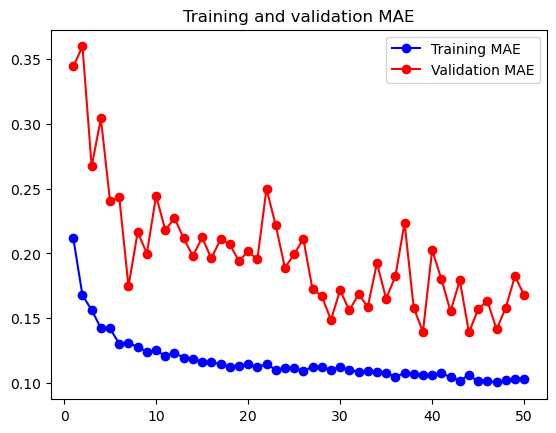

Lowest validation MAE:  79513.88026745435


In [10]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)

# Basic GRU

### sequence length = 8
This is the best approach by far, just using a simple GRU without any further addition or modification, reaching the desired MAE. This might be the case due to the "simplicity" of the problem, where the sales patterns tend to repeat themselves (christmas sale, black friday sale, and so on) without many deviations, thus a very complex model wouldn't be efficient to solve it.

Dimensionalities of 16, 32 and 48 have been tested, being 48 the one that provided the best MAE.

### sequence length = 12
The increase in sequence length provided no improvements at all, as opossed with the rest of the approaches. Thus, this approach is ruled out, as it gets overperformed by the bidirectional LSTM and the stacked GRU layers.

In [11]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.GRU(48)(inputs)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("models2/walmart_basic_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 gru (GRU)                   (None, 48)                8064      
                                                                 
 dense_1 (Dense)             (None, 1)                 49        
                                                                 
Total params: 8,113
Trainable params: 8,113
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(trainData,
                    epochs=50,
                    validation_data=testData,
                    callbacks=callbacks)

#model = keras.models.load_model("walmart_basic_rnn.keras") 
#print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
4005/4005 [==============================] - 74s 18ms/step - loss: 0.1078 - mae: 0.1923 - val_loss: 0.0902 - val_mae: 0.2330
Epoch 2/50
4005/4005 [==============================] - 73s 18ms/step - loss: 0.0522 - mae: 0.1432 - val_loss: 0.0765 - val_mae: 0.1988
Epoch 3/50
4005/4005 [==============================] - 74s 18ms/step - loss: 0.0373 - mae: 0.1265 - val_loss: 0.0487 - val_mae: 0.1569
Epoch 4/50
4005/4005 [==============================] - 71s 18ms/step - loss: 0.0342 - mae: 0.1205 - val_loss: 0.0440 - val_mae: 0.1545
Epoch 5/50
4005/4005 [==============================] - 79s 20ms/step - loss: 0.0327 - mae: 0.1157 - val_loss: 0.0336 - val_mae: 0.1241
Epoch 6/50
4005/4005 [==============================] - 85s 21ms/step - loss: 0.0310 - mae: 0.1123 - val_loss: 0.0328 - val_mae: 0.1256
Epoch 7/50
4005/4005 [==============================] - 85s 21ms/step - loss: 0.0307 - mae: 0.1122 - val_loss: 0.0307 - val_mae: 0.1190
Epoch 8/50
4005/4005 [==========================

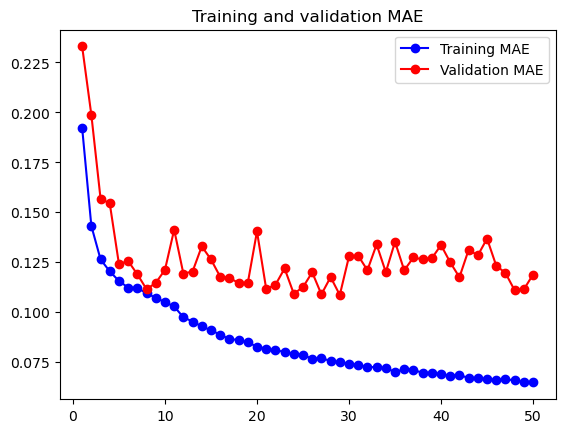

Lowest validation MAE:  62146.907937644624


In [13]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)

# Recurrent Dropout

### sequence length = 8
Different dropout values have been tested, ranging from 0.1 to 0.5, but in the end this didn't help improve the MAE at all, only provided worse results. The basic GRU approach didn't show overfitting, thus makes sense that this problem does not require to apply dropout to the networks. 

### sequence length = 12
The sequence length mean a drastic increase in performance for this approach, going from 109091 to 70014 MAE. This proves that sequence length 8 was too short, thus the dropout made the model learn worse, but with length 12 the dropout doesn't interfere as much in the learning process. Still, this problem shows that it does not need dropout at all, as shown by the better results of the other approaches.

In [ ]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.LSTM(32, recurrent_dropout=0.10)(inputs)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("models2/walmart_recurrent_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4992      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(trainData,
                    epochs=50,
                    validation_data=testData,
                    callbacks=callbacks)

Epoch 1/50
4005/4005 [==============================] - 107s 26ms/step - loss: 0.1478 - mae: 0.2411 - val_loss: 0.1675 - val_mae: 0.3083
Epoch 2/50
4005/4005 [==============================] - 138s 34ms/step - loss: 0.1171 - mae: 0.2069 - val_loss: 0.1036 - val_mae: 0.2350
Epoch 3/50
4005/4005 [==============================] - 127s 32ms/step - loss: 0.1005 - mae: 0.1973 - val_loss: 0.1069 - val_mae: 0.2524
Epoch 4/50
4005/4005 [==============================] - 130s 32ms/step - loss: 0.0917 - mae: 0.1911 - val_loss: 0.0681 - val_mae: 0.1908
Epoch 5/50
4005/4005 [==============================] - 130s 33ms/step - loss: 0.0774 - mae: 0.1803 - val_loss: 0.0652 - val_mae: 0.1926
Epoch 6/50
4005/4005 [==============================] - 111s 28ms/step - loss: 0.0714 - mae: 0.1773 - val_loss: 0.0753 - val_mae: 0.1935
Epoch 7/50
4005/4005 [==============================] - 146s 36ms/step - loss: 0.0694 - mae: 0.1734 - val_loss: 0.0752 - val_mae: 0.1879
Epoch 8/50
4005/4005 [===================

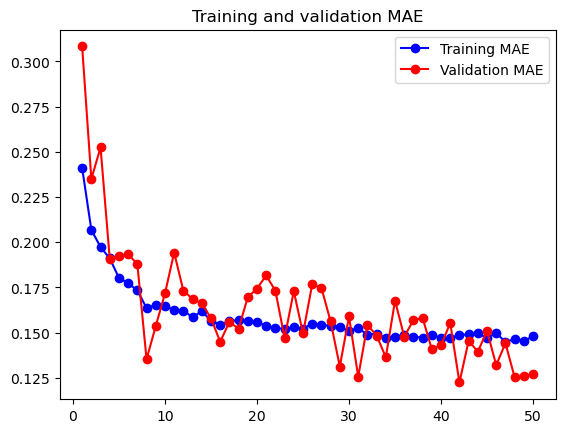

Lowest validation MAE:  70014.36030472748


In [16]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)

# Stacking Recurrent Layers

### sequence length = 8
This approach has the potential to provide even better results than the basic GRU, but we still would have to increase the number of training epochs, thus making it extremely inefficient compared to the other approach.

### sequence length = 12
The larger sequence length allows this more complex model to learn better, reaching results better than the previously unmached base GRU approach (64203 MAE). Still, the simpler bidirectional LSTM outperformed this approach.

In [17]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.GRU(48, return_sequences=True)(inputs)
x = layers.GRU(48)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("models2/walmart_stacked_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 gru_1 (GRU)                 (None, 12, 48)            8064      
                                                                 
 gru_2 (GRU)                 (None, 48)                14112     
                                                                 
 dense_3 (Dense)             (None, 1)                 49        
                                                                 
Total params: 22,225
Trainable params: 22,225
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(trainData,
                    epochs=50,
                    validation_data=testData,
                    callbacks=callbacks)

Epoch 1/50
4005/4005 [==============================] - 86s 21ms/step - loss: 0.0998 - mae: 0.1911 - val_loss: 0.0731 - val_mae: 0.1948
Epoch 2/50
4005/4005 [==============================] - 64s 16ms/step - loss: 0.0473 - mae: 0.1406 - val_loss: 0.0581 - val_mae: 0.1631
Epoch 3/50
4005/4005 [==============================] - 84s 21ms/step - loss: 0.0389 - mae: 0.1264 - val_loss: 0.0563 - val_mae: 0.1631
Epoch 4/50
4005/4005 [==============================] - 84s 21ms/step - loss: 0.0355 - mae: 0.1211 - val_loss: 0.0448 - val_mae: 0.1475
Epoch 5/50
4005/4005 [==============================] - 87s 22ms/step - loss: 0.0327 - mae: 0.1158 - val_loss: 0.0443 - val_mae: 0.1452
Epoch 6/50
4005/4005 [==============================] - 65s 16ms/step - loss: 0.0308 - mae: 0.1133 - val_loss: 0.0418 - val_mae: 0.1346
Epoch 7/50
4005/4005 [==============================] - 75s 19ms/step - loss: 0.0267 - mae: 0.1086 - val_loss: 0.0455 - val_mae: 0.1374
Epoch 8/50
4005/4005 [==========================

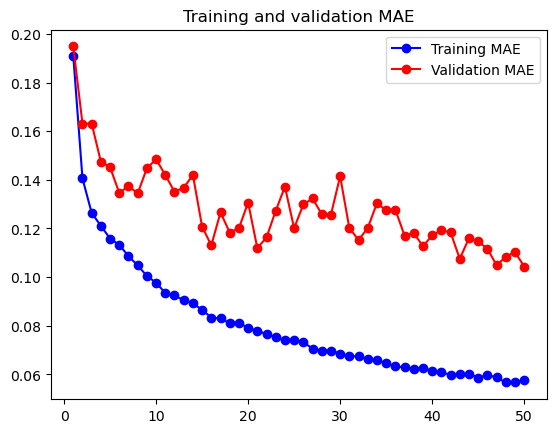

Lowest validation MAE:  59686.148152646674


In [19]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)

# Bidirectional RNNs

### sequence length = 8
The bidirectional LSTM approach also has the potential to overperform the basic GRU approach, but same as before, we would have to increase the number of epochs in order to make it viable.

### sequence length = 12
Increasing the sequence length improved this model far more than expected, overperforming all other approaches. In general, increasing the sequence length improved the performance of all models.

In [20]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.Bidirectional(layers.LSTM(32))(inputs)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("models2/walmart_bidirectional_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9984      
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,049
Trainable params: 10,049
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(trainData,
                    epochs=50,
                    validation_data=testData,
                    callbacks=callbacks)

Epoch 1/50
4005/4005 [==============================] - 62s 15ms/step - loss: 0.1204 - mae: 0.1962 - val_loss: 0.1267 - val_mae: 0.2722
Epoch 2/50
4005/4005 [==============================] - 48s 12ms/step - loss: 0.0807 - mae: 0.1636 - val_loss: 0.0821 - val_mae: 0.2129
Epoch 3/50
4005/4005 [==============================] - 58s 14ms/step - loss: 0.0633 - mae: 0.1476 - val_loss: 0.0703 - val_mae: 0.1910
Epoch 4/50
4005/4005 [==============================] - 58s 15ms/step - loss: 0.0522 - mae: 0.1364 - val_loss: 0.0732 - val_mae: 0.1748
Epoch 5/50
4005/4005 [==============================] - 63s 16ms/step - loss: 0.0400 - mae: 0.1250 - val_loss: 0.0646 - val_mae: 0.1658
Epoch 6/50
4005/4005 [==============================] - 61s 15ms/step - loss: 0.0348 - mae: 0.1192 - val_loss: 0.0501 - val_mae: 0.1471
Epoch 7/50
4005/4005 [==============================] - 58s 15ms/step - loss: 0.0325 - mae: 0.1164 - val_loss: 0.0482 - val_mae: 0.1456
Epoch 8/50
4005/4005 [==========================

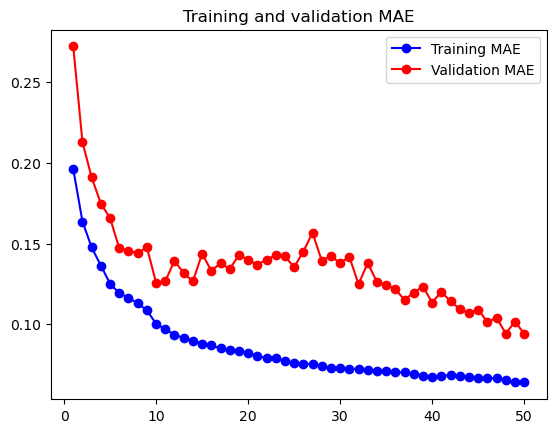

Lowest validation MAE:  53801.47027523962


In [22]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)